# Time series analysis
 Lund University

## Example code 8: Estimation using least-squares.

**Reference:**  
*An Introduction to Time Series Modeling*, 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
import sys
import os
import time

# Import tsa_lth package
sys.path.append(os.path.join('..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main'))
from tsa_lth import analysis


### Simulate some processes. To avoid mess with the LS implementation below, we use complex sinusoids.

In [ ]:
np.random.seed(1)
N  = 100 
w0 = 2*np.pi*np.array([0.1, 0.14])                           # Try with the second frequency at 0.11.
A0 = np.array([2, 0.4])
x1 = A0[0]*np.exp( 1j*w0[0]*np.arange(1, N+1) + 1j*np.random.rand()*2*np.pi )
x2 = A0[1]*np.exp( 1j*w0[1]*np.arange(1, N+1) + 1j*np.random.rand()*2*np.pi )
e  = ( np.random.randn(N) + 1j*np.random.randn(N) )/np.sqrt(2)    # For complex noise, you have to scale with sqrt(2).
y  = x1 + x2 + e

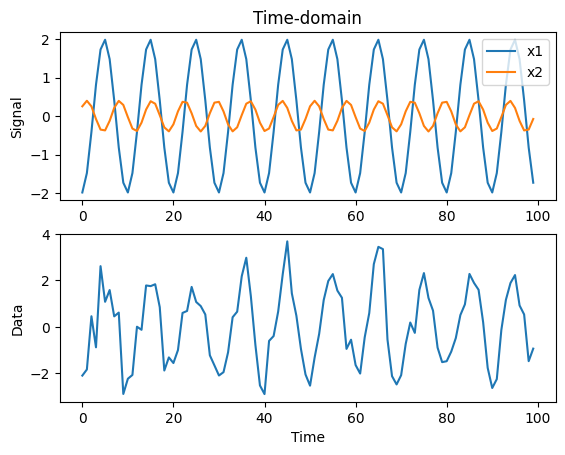

In [ ]:
# Plot realisations
plt.figure()
plt.subplot(211)
plt.plot(np.column_stack([np.real(x1), np.real(x2)]))
plt.title('Time-domain')
plt.ylabel('Signal')
plt.legend(['x1', 'x2'])
plt.subplot(212)
plt.plot( np.real(y) )
plt.ylabel('Data')
plt.xlabel('Time')
plt.show()

## Lets examine the periodogram estimates.

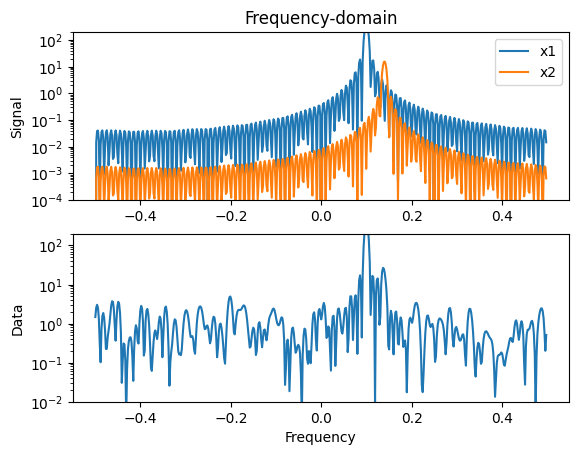

In [ ]:
Padd = 512
X1 = fftshift( np.abs( fft(x1, Padd) )**2 / N )
X2 = fftshift( np.abs( fft(x2, Padd) )**2 / N )
Y  = fftshift( np.abs( fft(y, Padd) )**2 / N )

ff = np.arange(Padd)/Padd - 0.5
plt.figure()
plt.subplot(211)
plt.semilogy(ff, np.column_stack([X1, X2]))
plt.title('Frequency-domain')
plt.ylabel('Signal')
plt.legend(['x1', 'x2'])
plt.ylim([1e-4, 2e2])
plt.subplot(212)
plt.semilogy(ff, Y)
plt.ylabel('Data')
plt.xlabel('Frequency')
plt.ylim([1e-2, 2e2])
plt.show()

## Try estimating the amplitudes using LS.

In [ ]:
X = np.exp( 1j*np.arange(1, N+1)[:, np.newaxis]*w0 )
theta = np.linalg.inv( X.conj().T @ X ) @ X.conj().T @ y
print('Estimation using LS, with known frequencies.')
print(f'  True amplitudes:      {np.sort(A0)[0]:.3f} and {np.sort(A0)[1]:.3f}.')
print(f'  Estimated amplitudes: {np.sort(np.abs(theta))[0]:.3f} and {np.sort(np.abs(theta))[1]:.3f}.')

Estimation using LS, with known frequencies.
  True amplitudes:      0.400 and 2.000.
  Estimated amplitudes: 0.467 and 2.005.


## What if we do not know the frequencies? 
Lets compute the cost function for all candidate frequencies. The below is a very inefficient implementation - why is that?

In [ ]:
ff = np.arange(1, Padd+1)/Padd - 0.5
C  = np.zeros((Padd, Padd))
start_time = time.time()
for k1 in range(Padd):
    for k2 in range(Padd):
        if k1 != k2:       # If it is the same frequencies, the matrix Xw'*Xw is not invertible. 
            Xw = np.exp( 1j*np.arange(1, N+1)[:, np.newaxis]*np.array([2*np.pi*ff[k1], 2*np.pi*ff[k2]]) )
            C[k1, k2] = np.real(y.conj() @ Xw @ np.linalg.inv( Xw.conj().T @ Xw ) @ Xw.conj().T @ y)
        else:
            Xw = np.exp( 1j*np.arange(1, N+1)[:, np.newaxis]*np.array([2*np.pi*ff[k1]]) )
            C[k1, k1] = np.real(y.conj() @ Xw @ np.linalg.inv( Xw.conj().T @ Xw ) @ Xw.conj().T @ y)

elapsed_time = time.time() - start_time
print(f'Computing the grid search took {elapsed_time:.2f} s.')

Computing the grid search took 4.88 s.


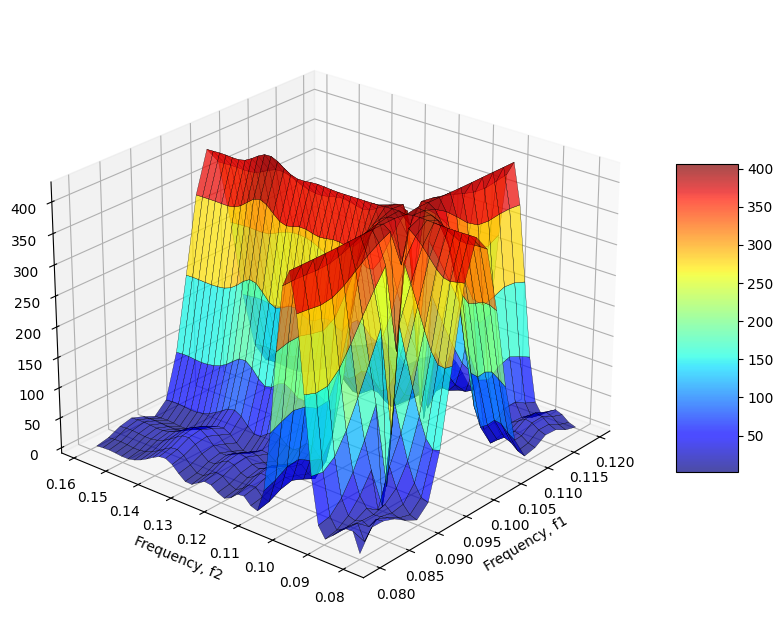

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x_idx = (ff >= 0.08) & (ff <= w0[0]/2/np.pi+0.02)
y_idx = (ff >= 0.08) & (ff <= w0[1]/2/np.pi+0.02)
ff_x = ff[x_idx]
ff_y = ff[y_idx]
C_zoom = C[np.ix_(x_idx, y_idx)]

FF1, FF2 = np.meshgrid(ff_x, ff_y)
surf = ax.plot_surface(FF1, FF2, np.real(C_zoom).T, cmap='jet', 
                       rstride=1, cstride=1, linewidth=0.2, 
                       edgecolor='k', alpha=0.7, antialiased=True)
ax.set_xlabel('Frequency, f1')
ax.set_ylabel('Frequency, f2')
ax.view_init(elev=25, azim=220)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()

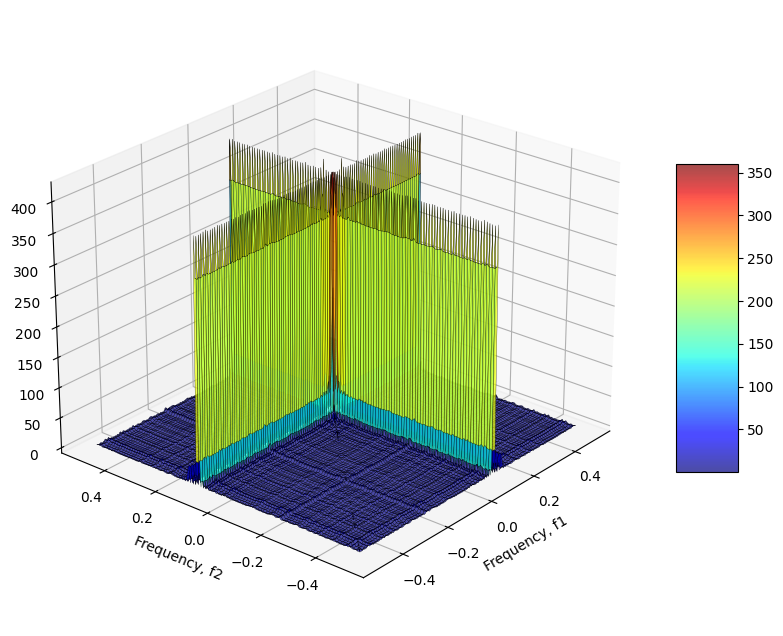

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
FF1, FF2 = np.meshgrid(ff, ff)
surf = ax.plot_surface(FF1, FF2, np.real(C).T, cmap='jet', 
                       rstride=5, cstride=5, linewidth=0.2, 
                       edgecolor='k', alpha=0.7, antialiased=True)
ax.set_xlabel('Frequency, f1')
ax.set_ylabel('Frequency, f2')
ax.view_init(elev=25, azim=220)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()